# E. Implementing Decision Function of SVM RBF Kernel

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

In [3]:
print(X.shape)
print(y.shape)

(5000, 5)
(5000,)


####  Split the data into  𝑋𝑡𝑟𝑎𝑖𝑛 (60),  𝑋𝑐𝑣 (20),  𝑋𝑡𝑒𝑠𝑡 (20)

In [4]:
X_train, X_cv, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
y_train, y_cv, y_test = np.split(y, [int(.6*len(y)), int(.8*len(y))])

In [5]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(3000, 5)
(1000, 5)
(1000, 5)
(3000,)
(1000,)
(1000,)


In [6]:
clf = SVC(gamma=0.001, C=100)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
y_pred = clf.predict(X_test)
support_vectors = clf.support_vectors_
N = len(clf.support_vectors_)
intercept = clf.intercept_
alpha = clf.dual_coef_

In [8]:
len(alpha[0])

538

In [9]:
def RBF_kernal(a,b):
    rbf = 0
    gamma = 0.001
    l2_norm = np.linalg.norm(a-b)
    rbf = np.exp(- gamma * (l2_norm**2))
    return rbf

In [10]:
#fcv= fcv + ((alpha[0][i] * (RBF_kernal_1(X_cv[i],X_cv[q]))) + intercept[0])
def decision_function(X_cv,intercept,N): 
    fcv_list = []
    
    for q in range(len(X_cv)):
        sum = 0
        for s in range(len(support_vectors)):
            sum = sum + alpha[0][s] * RBF_kernal(X_cv[q],support_vectors[s])
        
        final_sum = sum + intercept
        fcv_list.append(final_sum)
    return fcv_list  

In [11]:
fcv_calculated = np.array(decision_function(X_cv,intercept,N))
print(len(fcv_calculated))

1000


In [12]:
fcv_calculated[0:10]

array([[ 0.91901357],
       [ 1.66158685],
       [-2.07767   ],
       [-2.57429854],
       [-2.50803725],
       [-2.95389177],
       [ 1.4127627 ],
       [-2.26160487],
       [ 0.25485495],
       [ 1.67789609]])

In [13]:
fcv = clf.decision_function(X_cv)
len(fcv)

1000

In [14]:
fcv[0:10]

array([ 0.91901357,  1.66158685, -2.07767   , -2.57429854, -2.50803725,
       -2.95389177,  1.4127627 , -2.26160487,  0.25485495,  1.67789609])

Observation :
    I have compared calculated fcv  and fcv wih the decision function. Both have exactly same values.

In [15]:
sign_val = np.sign(fcv_calculated)
final_list_fcv = []
for r in range(len(sign_val)):
    if sign_val[r] >= 0 :
        final_list_fcv.append("Positive")
    else :
        final_list_fcv.append("Negative")      

In [16]:
final_list_fcv[0:10]

['Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive']

# F: Implementing Platt Scaling to find P(Y==1|X)

In [17]:
def sigmoid_function(w, x, b):
    yp=np.dot(x,w.T)+b
    return 1.0 / (1 + np.exp(-yp))

In [18]:
def log_loss(w, b, X, Y,y_pos,y_neg):
    N=len(X)
    sum_log=0
    
    if N==1:
        
        sum_log += Y * np.log10(sigmoid_function(w, X, b)) + (1-Y) * np.log10(1-sigmoid_function(w, X, b))
    else:
        for i in range(N):
            if Y[i]>0 :
                Y[i] = y_pos
            else:
                Y[i] = y_neg
            
            sum_log += Y[i] * np.log10(sigmoid_function(w, X[i], b)) + (1-Y[i]) * np.log10(1-sigmoid_function(w, X[i], b))

    return -1 * sum_log/N

In [19]:
def sgd_Logistic_Regression(X_train, y_train, n_epochs,w,b,y_pos,y_neg):
    eta0  = 0.0001
    alpha = 0.0001
    logloss_Train=[]
    N=len(X_train)
    
    for epoch in range(0,n_epochs):
       
        for i in range(0,N):
            Xi=X_train[i]
            yi=y_train[i]
                        
            w = ((1- eta0 * (alpha / N)) * w)+((eta0 * Xi)*(yi - sigmoid_function(w,Xi,b)))
            b = b + (eta0 * (yi-sigmoid_function(w,Xi,b)))
        
        train_loss = log_loss (w,b,X_train, y_train,y_pos,y_neg)
        logloss_Train.append(train_loss)
        
    # Plot train error in each iteration
    plt.figure()
    plt.plot(np.array(logloss_Train), label='Train LogLoss')
    #plt.plot(np.array(logloss_Test), label='Test LogLoss')
    plt.title("SGD Log Loss per iteration")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return w, b

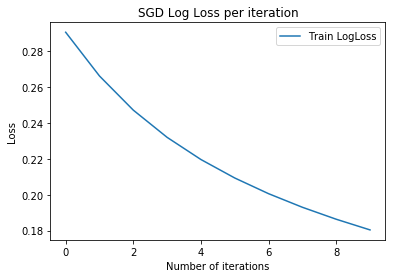

In [20]:
N_pos = 0
N_neg = 0
for r in range(len(final_list_fcv)):
    if final_list_fcv[r] == 'Positive':
        N_pos +=1
    else:
        N_neg +=1

y_pos = (N_pos + 1)/(N_pos+2)
y_neg = 1 /(N_neg +2)
w = np.zeros_like(fcv_calculated[0])
b = 0
n_epochs=10
#lr_rate=0.01
w_optimal, b_optimal = sgd_Logistic_Regression(fcv_calculated, y_train,n_epochs,w,b,y_pos,y_neg)

In [21]:
w_optimal, w_optimal.shape, b_optimal

(array([0.32211801]), (1,), -0.3692194129061505)

In [22]:
ftest_calculated = np.array(decision_function(X_test,b_optimal,N))
print(len(ftest_calculated))

1000


In [25]:
ftest_calculated[0:10]

array([-3.6971949 , -5.52863654, -7.70077836, -2.53003421, -1.66431819,
       -2.9082659 , -5.34052115, -6.26658636, -6.75085565, -5.29589637])

In [65]:
probability_list = []

for r in range(len(y_test)):
    if y_test[r] == 1 :
        prob = 1 / (1 + np.exp(-((w_optimal* ftest_calculated[r])+ b_optimal)))
        probability_list.append(prob)

In [67]:
len(probability_list)

314

In [68]:
probability_list[0:10]

[array([0.28795718]),
 array([0.21315289]),
 array([0.29075721]),
 array([0.29025363]),
 array([0.24039342]),
 array([0.24208809]),
 array([0.20802808]),
 array([0.33444646]),
 array([0.27859011]),
 array([0.27297395])]